In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from keras.optimizers import Adam, SGD, Adadelta

In [2]:
x_train_scaled = pd.read_csv('260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                            ...                       
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.468042  0.335792   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.000000  0.159464   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.335173  0.241577   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.181256  0.297248   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.319013  0.306320   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.209212  0.301844   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.408592  0.042243   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.514164  0.364434   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.428242  0.315197   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.261123  0.099541   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
55_control             0.0  0.609518  0.535456        0.0  0.543158   
168_CD_plain           0.0  0.173529  0.018188        0.0  0.623796   
72_control             0.0  0.659563  0.000000        0.0  0.853118   
120_control            0.0  0.837676  0.480372        0.0  0.392582   
258_CD_plain           0.0  0.893448  0.485539        0.0  0.259900   
...                    ...       ...       ...        ...       ...   
15_CD_plain            0.0  0.643267  0.143476        0.0  0.262892   
182_CD_plain           0.0  0.765285  0.527984        0.0  0.413798   
164_CD_plain           0.0  0.930260  0.481733        0.0  0.273699   
53_CD_plain            0.0  0.877855  0.628071        0.0  0.183718   
97_CD_plain            0.0  0.156787  0.293838        0.0  0.561414   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
55_control     0.622641           0.0     1.0  
168_CD_plain   0.301179           0.0     0.0  
72_control     0.431083           0.0     0.0  
120_control    0.390569           0.0     0.0  
258_CD_plain   0.431818           0.0     0.0  
...                 ...           ...     ...  
15_CD_plain    0.189790           0.0     0.0  
182_CD_plain   0.270021           0.0     0.0  
164_CD_plain   0.433093           0.0     0.0  
53_CD_plain    0.302030           0.0     0.0  
97_CD_plain    0.027077           0.0     0.0  

[182 rows x 219 columns]

In [3]:
x_test_scaled = pd.read_csv('260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.339788   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.354602   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.320002   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.445680   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.419254   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.379431   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.181052   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.331961   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.416087   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.270050   

                    ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                 
253_CD_plain       0.326732           0.0  0.862246  0.074473        0.0   
105_CD_plain      -0.031527           0.0  0.717305  0.039214        0.0   
2_CD_plain         0.379134           0.0  0.604202  0.610072        0.0   
184_CD_plain       0.178908           0.0  0.702114  0.325357        0.0   
312_CD_plain       0.312215           0.0  0.821584  0.632007        0.0   
...                     ...           ...       ...       ...        ...   
107_CD_plain       0.233196           0.0  0.759342  0.567491        0.0   
279_CD_plain       0.342262           0.0  0.639644  0.540444        0.0   
179_CD_plain       0.275577           0.0  0.886616  0.658049        0.0   
70_CD_deep_ulcer   0.252402           0.0  0.931974  0.370181        0.0   
256_CD_deep_ulcer  0.268483           0.0  0.711803  0.243749        0.0   

                      MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                    
253_CD_plain       0.498941   0.349920           0.0     0.0  
105_CD_plain       0.697073   0.268224           0.0     0.0  
2_CD_plain         0.324065   0.375123           0.0     0.0  
184_CD_plain       0.390919   0.185509           0.0     0.0  
312_CD_plain       0.183158   0.271359           0.0     0.0  
...                     ...        ...           ...     ...  
107_CD_plain       0.404604   0.190411           0.0     0.0  
279_CD_plain       0.397274   0.061934           0.0     0.0  
179_CD_plain       0.259391   0.471132           0.0     0.0  
70_CD_deep_ulcer   0.463922   0.413834           0.0     0.0  
256_CD_deep_ulcer  0.345240   0.380147           0.0     0.0  

[78 rows x 219 columns]

In [4]:
sh = x_train_scaled.head(1).shape

In [5]:


# class AutoEncoder(Model):

#     def __init__(self, n_inputs, init_fn, n_bottleneck=32):

#         super().__init__()

#         self.encoder = Sequential(
#             [

#                 Input(shape=(n_inputs,)),
#                 # encoder level 1
#                 Dense(n_inputs*2, kernel_initializer=init_fn,
#     bias_initializer=initializers.Zeros()),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # encoder level 2
#                 Dense(n_inputs),
#                 BatchNormalization(),
#                 LeakyReLU(),
#                 # bottleneck
#                 Dense(n_bottleneck)
#             ]
#         )



#     def call(self, inputs):

#         encoded = self.encoder(inputs)
#         return encoded

In [6]:
# n_bottleneck = 32
# initializer = tf.keras.initializers.GlorotUniform()
# auto_encoder = AutoEncoder(219,initializer, n_bottleneck)

In [7]:
# auto_encoder.encoder.load_weights("encoder_ckpt")

In [8]:
# auto_encoder.build(sh) 
# auto_encoder.summary()

In [9]:
# auto_encoder.encoder.summary()

In [10]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [11]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [12]:
n_inputs = 219
n_bottleneck = 32
encoder_base = Sequential(
            [

#                 Input(shape=(n_inputs,)),
                # encoder level 1
                Dense(n_inputs*2),
                BatchNormalization(),
                LeakyReLU(),
                # encoder level 2
                Dense(n_inputs),
                BatchNormalization(),
                LeakyReLU(),
                # bottleneck
                Dense(n_bottleneck)
            ]
        )

In [13]:
encoder_base.load_weights("encoder_ckpt")

In [14]:
# encoder_base.trainable = False
encoder_base.build(sh) 
encoder_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [15]:
x_train_scaled.shape

(182, 219)

In [16]:
# inputs = keras.Input(shape=(219,))
# x = encoder_base(inputs, training=False)
inter = Dense(24, activation='relu')

In [17]:
# inter = Dense(24, activation='relu')(x)
# outputs = Dense(3, activation='softmax')(inter)
# compound_model = Model(inputs, outputs)

compound_model = encoder_base
compound_model.add(Dense(24, activation='relu'))
compound_model.add(Dense(3, activation='softmax'))

In [18]:
x_train_scaled.head(1).values.flatten().shape

(219,)

In [19]:
y = compound_model(x_train_scaled.head(1).values)

In [20]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [21]:
for i in range(7):
    compound_model.layers[i].trainable = False

compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 438)                  96360     
                                                                 
 batch_normalization (BatchN  (1, 438)                 1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 438)                  0         
                                                                 
 dense_1 (Dense)             (1, 219)                  96141     
                                                                 
 batch_normalization_1 (Batc  (1, 219)                 876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (1, 219)                  0

In [22]:
from keras.optimizers import Adam, SGD, Adadelta

opt = Adam(learning_rate=0.001)

compound_model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
history = compound_model.fit(x_train_scaled, disease_labels_train, epochs=100)

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 1.5236 - accuracy: 0.3901
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 1.2860 - accuracy: 0.4121
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 1.2016 - accuracy: 0.3846
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 1.1039 - accuracy: 0.4011
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 1.0145 - accuracy: 0.4505
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9486 - accuracy: 0.4725
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 0.9046 - accuracy: 0.5330
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8670 - accuracy: 0.5275
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8365 - accuracy: 0.5604
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8127 - accuracy: 0.5879
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 1ms/step - loss: 0.5671 - accuracy: 0.7582
Epoch 85/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5687 - accuracy: 0.7527
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5643 - accuracy: 0.7527
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.5626 - accuracy: 0.7527
Epoch 88/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5609 - accuracy: 0.7637
Epoch 89/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5596 - accuracy: 0.7692
Epoch 90/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5576 - accuracy: 0.7912
Epoch 91/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5562 - accuracy: 0.7967
Epoch 92/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5611 - accuracy: 0.7637
Epoch 93/100
6/6 [==============================] - 0s 1ms/step - loss: 0.5554 - accuracy: 0.7692
Epoch 94/100
6/6 [===============

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


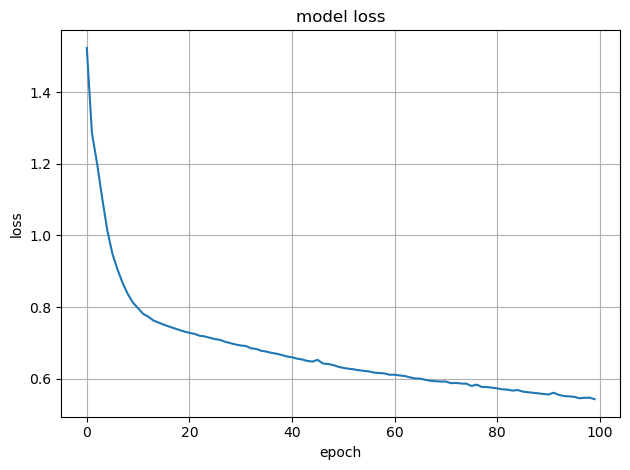

In [25]:
# summarize history for loss
plt.figure()
plt.grid()
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['Training', 'Validation'], loc='upper left')
plt.tight_layout()
# plt.savefig('autoencoder_learning_curve_loss.png', dpi=300)
plt.show()

In [26]:
test_loss, test_acc = compound_model.evaluate(x_test_scaled, disease_labels_test, verbose=2)

print('\nTest accuracy:', test_acc)

3/3 - 0s - loss: 0.8420 - accuracy: 0.5769 - 119ms/epoch - 40ms/step

Test accuracy: 0.5769230723381042


In [27]:
compound_model.predict(x_test_scaled.head(1))[0]

1/1 [==============================] - 0s 102ms/step


array([0.5802091 , 0.40025923, 0.01953169], dtype=float32)

In [28]:
x_test_scaled.iloc[[0],:]

AADAC    APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                
253_CD_plain  0.869185  0.84188  0.930171  0.886737  0.835678  0.297964   

                    C6  CEACAM7    CHI3L1    ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                          ...                       
253_CD_plain  0.668498  0.26667  0.278122  0.93352  ...  0.339788  0.326732   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
253_CD_plain           0.0  0.862246  0.074473        0.0  0.498941   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
253_CD_plain    0.34992           0.0     0.0  

[1 rows x 219 columns]

## SHAP evaluation

In [29]:
import shap

C:\Users\shard\anaconda3\envs\mvp4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# explainer = shap.KernelExplainer(model=compound_model.predict, data=x_train_scaled, link="logit")

In [31]:
import sys
sys.path.insert(0,r"C:\Users\shard\OneDrive - University of Cambridge\MPhil-Sonny\research project\exploring dataset\gene_shap_minimal")

In [32]:

sys.path

['C:\\Users\\shard\\OneDrive - University of Cambridge\\MPhil-Sonny\\research project\\exploring dataset\\gene_shap_minimal',
 'C:\\Users\\shard\\OneDrive - University of Cambridge\\MPhil-Sonny\\research project\\exploring dataset',
 'C:\\Program Files (x86)\\Eclipse\\Sumo\\tools',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\python310.zip',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\DLLs',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\lib',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4',
 '',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\lib\\site-packages',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\lib\\site-packages\\win32',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\shard\\anaconda3\\envs\\mvp4\\lib\\site-packages\\Pythonwin']

In [33]:
from gene_shap_minimal import objects

In [34]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

getting explainer
6/6 [==============================] - 0s 1ms/step


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [35]:
type(explainer)

explainers._kernel.Kernel

In [36]:
# import geneSHAP

In [37]:
# explainer = shap.KernelExplainer(model=compound_model.predict, data=x_train_scaled, link="logit")

In [38]:
# shap_values = explainer.shap_values(X=x_test_scaled)

## Save SHAP values

In [39]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [40]:


with open("shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [41]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [42]:
idx = 11
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC    APOA1    APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                              
58_CD_plain  0.712765  0.67885  0.86582  0.855696  0.828452  0.498697   

                   C6   CEACAM7    CHI3L1    ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                          ...                       
58_CD_plain  0.567772  0.352862  0.317254  0.76505  ...  0.211571  0.283032   

             LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  PCBP1_AS1  \
Patient_ID                                                                      
58_CD_plain           0.0  0.703328  0.556984        0.0  0.415272   0.225017   

             LOC100133165  DNAJB8  
Patient_ID                         
58_CD_plain           0.0     0.0  

[1 rows x 219 columns]

In [43]:
x_test_scaled.iloc[[0],:]

AADAC    APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                
253_CD_plain  0.869185  0.84188  0.930171  0.886737  0.835678  0.297964   

                    C6  CEACAM7    CHI3L1    ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                          ...                       
253_CD_plain  0.668498  0.26667  0.278122  0.93352  ...  0.339788  0.326732   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
253_CD_plain           0.0  0.862246  0.074473        0.0  0.498941   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
253_CD_plain    0.34992           0.0     0.0  

[1 rows x 219 columns]

In [44]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 10ms/step
Prediction probabilities for patient: [0.01563753 0.64952993 0.33483252]
Predicted class:


#### Control

In [45]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [46]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [47]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [48]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 11
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

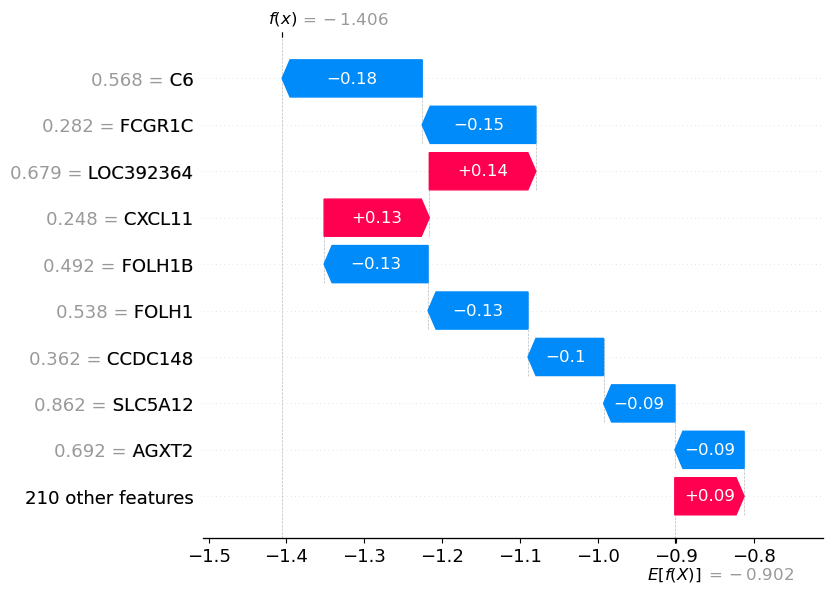

In [49]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [50]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [52]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

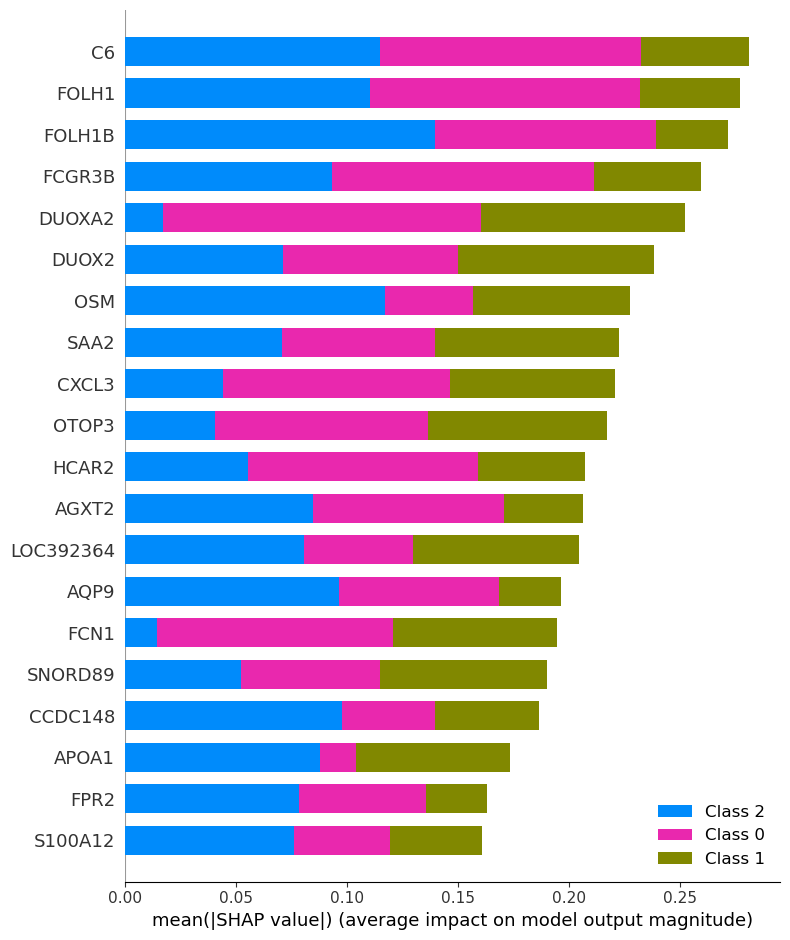

In [53]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


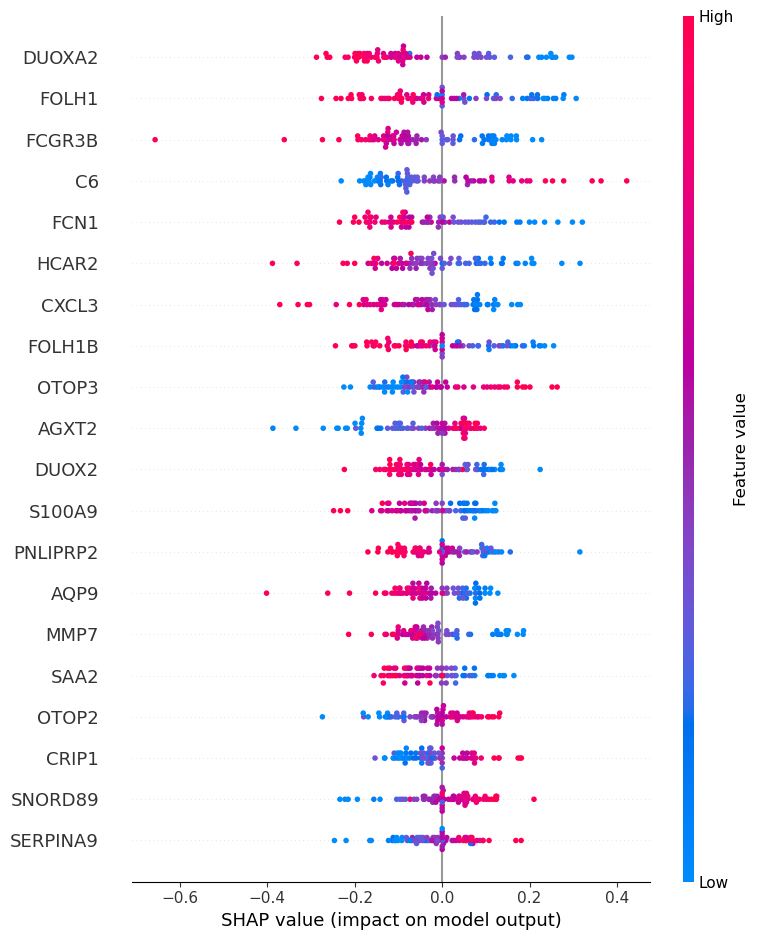

In [54]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

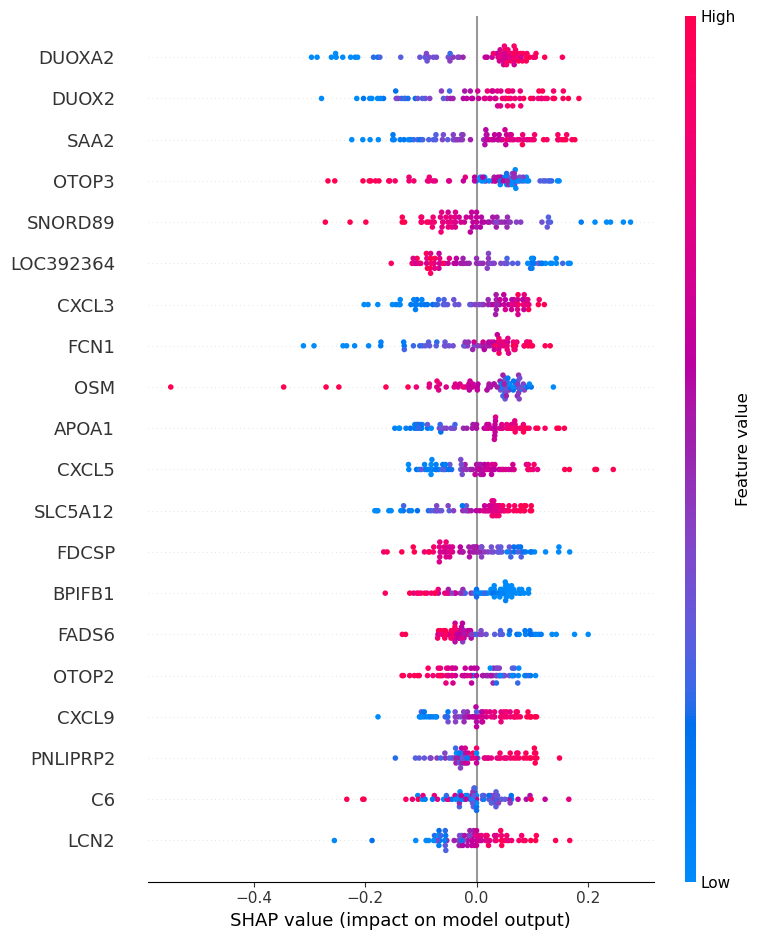

In [55]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

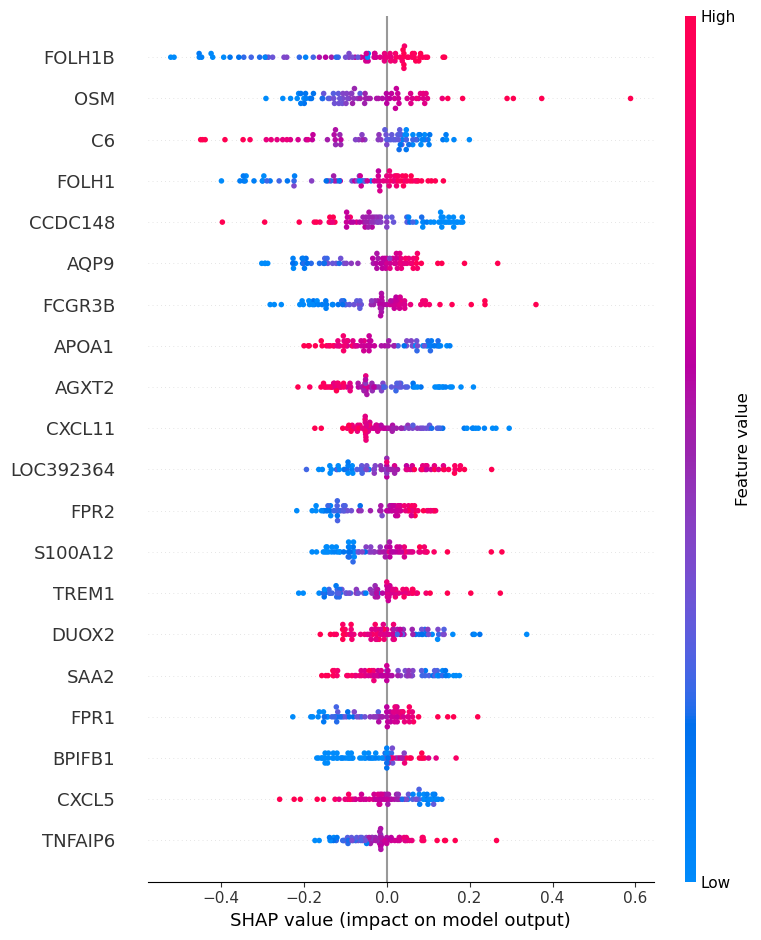

In [56]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

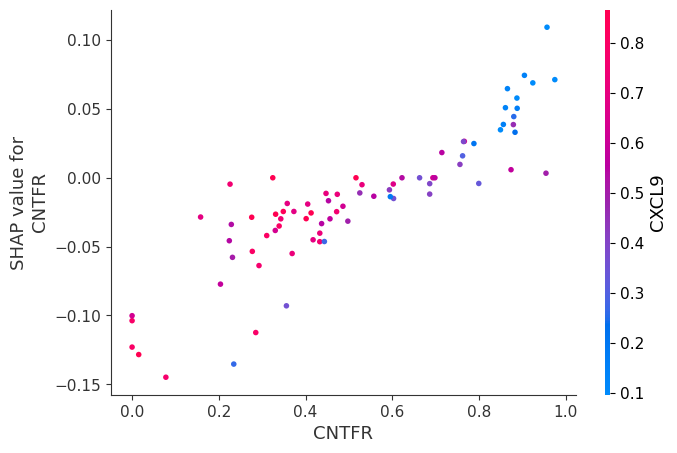

In [57]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

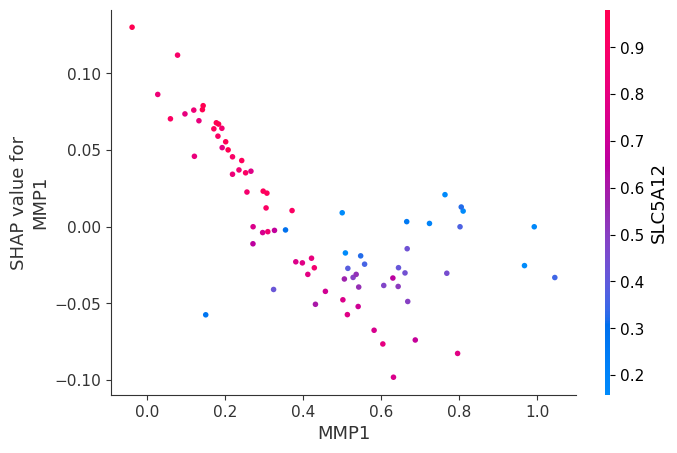

In [58]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

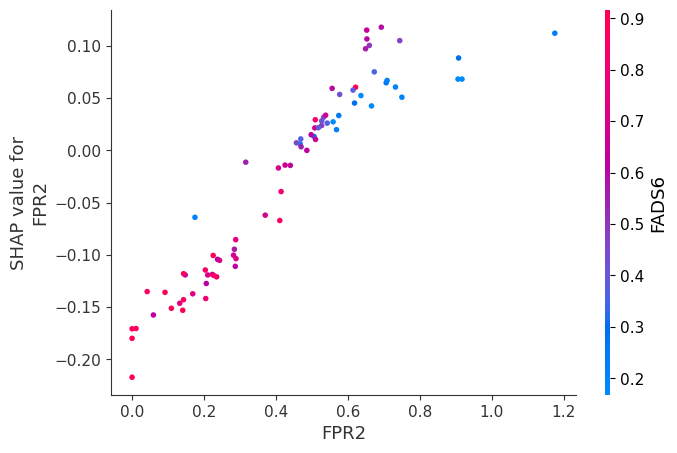

In [59]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [60]:
# clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

In [67]:
# clustering

In [62]:
row = 8
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

In [63]:
type(exp)

shap._explanation.Explanation

In [64]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [65]:

with open("clust", "rb") as fp:   # Unpickling
    clustering = pickle.load(fp)

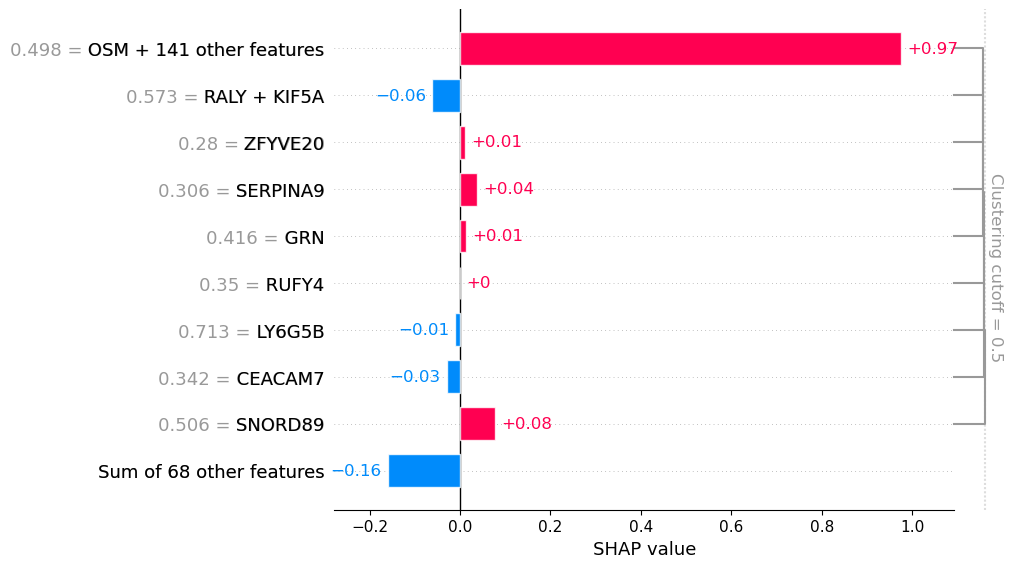

In [66]:
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, 
               clustering=clustering)

In [ ]:
# clustering = gene_shap.utils.hclust(x_test_scaled, disease_labels_test) # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
# gene_shap.plots.bar(shap_values_exp, clustering=clustering)

In [ ]:
# Fits the explainer
# explainer = gene_shap.Explainer(classifier.predict, x_test_scaled)

In [ ]:
# explainer = gene_shap.Explainer(classifier)

In [ ]:
# shap_values = explainer(x_test_scaled)

In [ ]:
# shap_values.shape

In [ ]:
# Prints the SHAP feature importances
# print_feature_importances_shap_values(shap_values, X.columns)

In [ ]:
# gene_shap.plots.bar(shap_values)

In [ ]:
# Plots the beeswarm
# gene_shap.plots.beeswarm(shap_values)